In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '21/05/2020'
id_noticia = '236522'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'

In [3]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[0]

In [4]:
# Prepare
dfL.set_index(['Provincia'], inplace=True)
del dfL['PCR Positivo']
del dfL['UCI']
#dfL.rename(columns={'Hospitalización': 'Ingresados', 'Curados': 'Altas', 'Fallecimientos': 'Bajas'}, inplace=True)
dfL['Fecha'] = fecha

# A partir del 14/05/2020 se cambia el formato del dato añadiendo en la misma columna el número de nuevos casos
dfL['Hospitalización'] = dfL['Hospitalización'].str.split(' ').str[0]
dfL['Curados'] = dfL['Curados'].str.split(' ').str[0]
dfL['Fallecimientos'] = dfL['Fallecimientos'].str.split(' ').str[0]

dfL

,Hospitalización,Fallecimientos,Curados,Fecha
Provincia,,,,
Almería,232,52,551,21/05/2020
Cádiz,575,147,721,21/05/2020
Córdoba,558,111,1.460,21/05/2020
Granada,1.191,280,2.642,21/05/2020
Huelva,219,48,437,21/05/2020
Jaén,761,177,1.220,21/05/2020
Málaga,1.474,281,2.537,21/05/2020
Sevilla,1.200,279,2.056,21/05/2020
Total,6.210,1.375,11.624,21/05/2020


In [5]:
# Save to csv
campos_ordenados = ['Hospitalización','Curados','Fallecimientos','Fecha']
dfL[campos_ordenados].to_csv(filename, encoding='utf-8', header=False, mode='+a', index_label='Provincia')

In [6]:
# Load full csv
df = pd.read_csv(filename, thousands='.')

In [7]:
# Prepare
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
last_fecha = df['Fecha'].max()
df.set_index(['Provincia', 'Fecha'], inplace=True)
df.sort_index(inplace=True)

In [8]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').pct_change() * 100
dfV.tail()

Hospitalización   Curados  Fallecimientos
Provincia Fecha                                                
Total     2020-05-17         0.211005  2.829732        0.221402
          2020-05-18         0.064788  0.565451        0.000000
          2020-05-19        -0.032373  0.674726        0.220913
          2020-05-20         0.323834  5.082379        0.734754
          2020-05-21         0.225952  2.967490        0.291758

In [9]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]

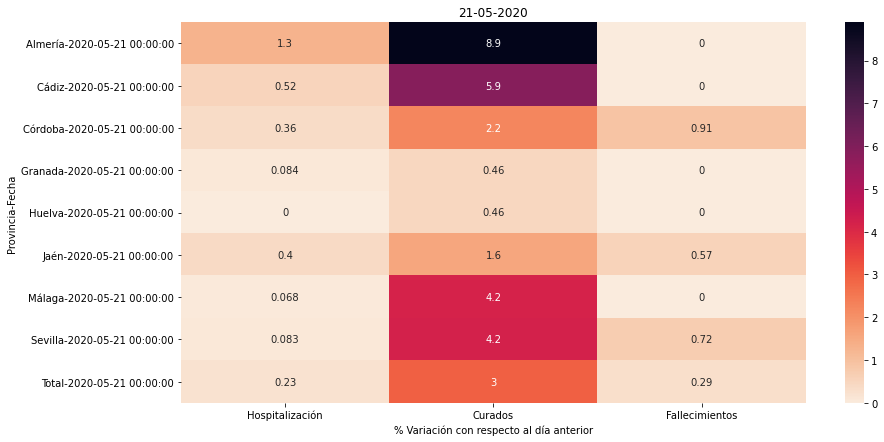

In [10]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG, annot=True, cmap=cmap)

# Add label for horizontal axis
plt.xlabel('% Variación con respecto al día anterior')
plt.show()

In [11]:
provincia = 'Total'
dias = 15
data = df.loc[provincia][['Hospitalización', 'Curados', 'Fallecimientos']].diff().tail(dias).copy()
titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia


In [12]:
print(titulo)
print(data)

Nuevos casos en los últimos 15 días en Total
            Hospitalización  Curados  Fallecimientos
Fecha                                               
2020-05-07             15.0    397.0            13.0
2020-05-08             11.0    359.0             7.0
2020-05-09             31.0    344.0            16.0
2020-05-10             11.0    241.0             3.0
2020-05-11             12.0    185.0             2.0
2020-05-12              9.0     92.0             4.0
2020-05-13             13.0    184.0             6.0
2020-05-14             14.0    437.0             4.0
2020-05-15             18.0    230.0             8.0
2020-05-16             15.0    171.0            11.0
2020-05-17             13.0    292.0             3.0
2020-05-18              4.0     60.0             0.0
2020-05-19             -2.0     72.0             3.0
2020-05-20             20.0    546.0            10.0
2020-05-21             14.0    335.0             4.0


Nuevos casos en los últimos 15 días en Total. (Nuevos ingresos hospitalarios)


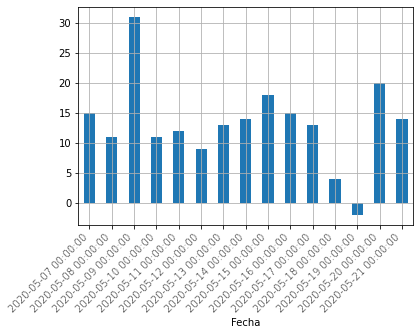

In [13]:
print(titulo + '. (Nuevos ingresos hospitalarios)')
data['Hospitalización'].plot(kind='bar', grid=True)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

In [14]:
# Fecha de último ingreso en hospital
data = df.loc[provincia][['Hospitalización']].diff().copy()
data.sort_index(ascending=False, inplace=True)

In [15]:
print('Ingresos recientes en hospital en ' + provincia)
data[data['Hospitalización'] > 0].head(1)

Ingresos recientes en hospital en Total


,Hospitalización
Fecha,
2020-05-21,14.0
